# Calculations to design the questionnaire

In [12]:
import numpy as np
from scipy import stats
from scipy import special
import matplotlib.pyplot as plt
import math

### Geometry

In [11]:
total_height = 9
crest_legth = 4
slope = 3
angle_slope = math.atan(1/3)
# print(angle_slope*180/np.pi)
slope_length = 9/math.sin(angle_slope)
# print(slope_length)

28.460498941515414


### Boundary conditions: overtopping events at the beginning of the slope

It should be noted that the equations below should be applied considering the breaking/non breaking nature of the waves, their experimental ranges and values of influence parameters. Here, they are used as a fast tool to assess the pre-design of a 2D 'experiment' so influence parameters are set to 1 and non-breaking are assumed.

In [105]:
def steepness(Hs, Tm0):
    return Hs/((9.81*Tm0**2)/2/np.pi)

def iribarren(Hs, Tm0, angle_slope):
    return np.tan(angle_slope)/np.sqrt(steepness(Hs, Tm0))

def params_distr_vols(q, Hs, Tm0, Pov):
    Tm = 1.1*Tm0
    b = 0.73 + 55*(q/(9.81*Hs*Tm0))**(0.8)
    a = (1/special.gamma(1 + 1/b))*(q*Tm/Pov)
    return a, b

def pov(Rc, Ru):
    return np.exp(-((np.sqrt(-np.log(0.02)))*Rc/Ru)**2)

def Ru(Hs, Tm0, angle_slope):
    ru = 1.65*Hs*1*1*1*iribarren(Hs, Tm0, angle_slope)
    max_value = Hs*1*1*(4-1.5/iribarren(Hs, Tm0, angle_slope))
    return min(ru, max_value)

def mean_discharge(Hs, Tm0, Rc, angle_slope):
    estimation = 0.023*np.sqrt(9.81*Hs**3)*1*iribarren(Hs, Tm0, angle_slope)*np.exp(-(2.7*Rc/(Hs*iribarren(Hs, Tm0, angle_slope)))**1.3)
    max_value = 0.09*np.sqrt(9.81*Hs**3)*np.exp(-(1.5*Rc/Hs)**1.3)
    return min(estimation, max_value)

def weibull_cdf(V, a, b):
    return 1 - np.exp(-(V/a)**b)

def weibull_icdf(P, a, b):
    return a*(-np.log(1-P))**(1/b)

def individual_events(Hs, Tm0, Rc, angle_slope, Pov, n_samples, n_seed):
    q_mean = mean_discharge(Hs, Tm0, Rc, angle_slope)
    a, b = params_distr_vols(q_mean, Hs, Tm0, Pov)
    unif_samples = stats.uniform.rvs(0, 1, size = n_samples, random_state=n_seed)
    V_samples = weibull_icdf(unif_samples, a, b)
    vel_samples = 4.5*V_samples**0.3
    h_samples = 0.133*V_samples**0.5
    T_samples = 3.9*V_samples**0.46
    samples = np.vstack((V_samples, vel_samples, h_samples, T_samples)).T
    return samples

In [122]:
# Input variables
Hs = 1
Tm0 = 4.5
water_level = 5
Rc = total_height - water_level
t_storm = 6 #hours of storm

print(iribarren(Hs, Tm0, angle_slope))

#Number of overtopping events
n_events = np.round((t_storm*3600/(1.1*Tm0))*pov(Rc, Ru(Hs, Tm0, angle_slope)))


#Generate overtopping events
n_samples = int(n_events)
samples = individual_events(Hs, Tm0, Rc, angle_slope, pov(Rc, Ru(Hs, Tm0, angle_slope)), 
                            n_samples, 1)
samples


1.8742858590396132


array([[9.60990753e-03, 1.11693597e+00, 1.30380081e-02, 4.60378934e-01],
       [3.11680371e-02, 1.58973725e+00, 2.34804474e-02, 7.90989931e-01],
       [8.94834857e-08, 3.45728659e-02, 3.97853412e-05, 2.23288491e-03],
       [5.52111071e-03, 9.45846041e-01, 9.88245553e-03, 3.56776940e-01],
       [1.79842816e-03, 6.75585690e-01, 5.64024784e-03, 2.12968529e-01],
       [9.14848636e-04, 5.51591147e-01, 4.02277982e-03, 1.56057721e-01]])

### Flow characteristics along the crest and slope: 1D shallow water equations

In [123]:
def max_u_horizontal(x_coord, friction, inst_Q, u_0):
    u_horizontal = (friction*x_coord/2/inst_Q+1/u_0)**(-1)
    return u_horizontal

def max_u_slope(x_coord, u_0, friction, inst_Q, angle_slope):\
    # note tht x_coord is defined along the slope
    alpha = (9.81*np.sin(angle_slope))**(1/3)
    beta = np.sqrt(friction/2/inst_Q)
    mu = u_0 - alpha/beta
    u_slope = alpha/beta + mu*np.exp(-3*(beta**2)*alpha*x_coord/np.cos(angle_slope))
    return u_slope

In [124]:
# define parameters
friction = 0.1

# max velocity at the end of the crest for all the samples
u_end_crest = max_u_horizontal(4, friction, samples[:,1]*samples[:,2], samples[:,1])

# max velocity at the slope for all the samples
coordinates_to_evaluate = np.linspace(0, slope_length, 100)
friction = np.array([friction]*len(coordinates_to_evaluate))
max_velocities = np.empty((len(samples), len(coordinates_to_evaluate)))

for i in range(len(samples)):
    max_velocities[i, :]=max_u_slope(coordinates_to_evaluate, u_end_crest[i], friction, 
                                 samples[i,1]*samples[i,2], angle_slope)

# Plot max velocities
# plt.plot(coordinates_to_evaluate, max_velocities[0, :], color='blue', alpha=0.3)

### Cumulative erosion given maximum velocities

In [125]:
# coordinates_to_evaluate = np.linspace(0, slope_length, 100) #from previous

# compute turbulence parameters for each event and coordinate
r_0 = np.empty([len(samples), len(coordinates_to_evaluate)])
for i in range(len(samples)):
    for j in range(len(coordinates_to_evaluate)):
        r_0[i,j] = np.sqrt(9.81*samples[i,1]*samples[i,2]*np.sin(angle_slope)/max_velocities[i,j]**3)
omega = 1.5 + 5*r_0

# initialize erosion depth array
erosion_depth = np.empty([len(coordinates_to_evaluate),1])

#define parameters
critical_velocity = 5  # m/s
inverse_cover_strength = 2*10**(-6)  # s/m

# compute erosion depth
for j in range(len(coordinates_to_evaluate)):
    for i in range(len(samples)):
        if omega[i,j]**2*max_velocities[i,j]**2 > critical_velocity**2:
            erosion_depth[j] = erosion_depth[j] + (omega[i,j]**2*max_velocities[i,j]**2-critical_velocity**2)*inverse_cover_strength*samples[i, 3]

Text(0, 0.5, 'Erosion depth (m)')

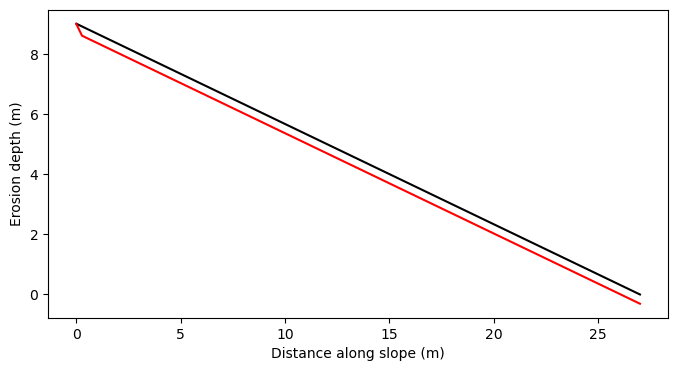

In [126]:
# Plot erosion depth
slope_heights = np.linspace(9, 0, 100)
projected_x_coord = coordinates_to_evaluate*np.cos(angle_slope)

fig, axes = plt.subplots(1,1, figsize=(8,4))
axes.plot(projected_x_coord, slope_heights, color='black', label ='Slope profile')
axes.plot(projected_x_coord, slope_heights - erosion_depth.flatten(), color='red', label = 'Eroded profile')
axes.set_xlabel('Distance along slope (m)')
axes.set_ylabel('Erosion depth (m)')

In [127]:
max(erosion_depth)

array([0.30723907])

End of design